In [110]:
import neptune

run = neptune.init_run(project="sergey.b.berezin/Passengers")
run["description"] = "Decrease window size"

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/sergey.b.berezin/Passengers/e/PAS-14


In [111]:
git_status = ! git status
if any("working tree clean" in line for line in git_status):
    git_log = ! git log --pretty=format:'%H' -n 1
    commit_hash = git_log[0]
    run["commit_hash"] = commit_hash
    print(f'Commit hash {commit_hash} is associated with the run')
else:
    print("Please commit your latest changes to track commit in Neptune")

Please commit your latest changes to track commit in Neptune


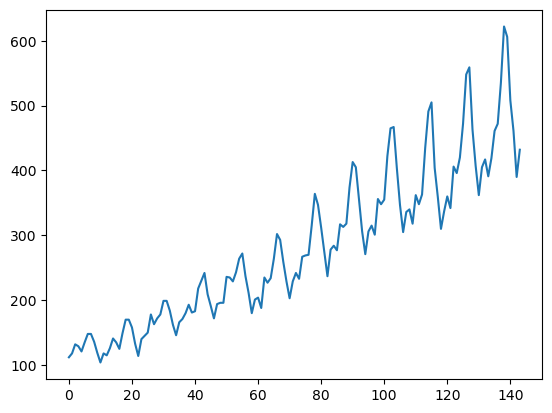

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [112]:
import pandas
import matplotlib.pyplot as plt
dataset = pandas.read_csv('airline-passengers.csv')
plt.plot(dataset["Passengers"])

run["data/plot"].upload(plt.gcf()) # plt.gcf() должна быть перед вызовом plt.show()
run["data/airline-passengers.csv"].track_files("./airline-passengers.csv")

plt.show()
dataset

In [113]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

passengers = np.reshape(dataset["Passengers"].values.astype('float32'), (-1,1))
scaler = MinMaxScaler(feature_range=(0, 1))
passengers = scaler.fit_transform(passengers)
passengers

array([[0.01544401],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853],
       [0.05984557],
       [0.08494207],
       [0.08494207],
       [0.06177607],
       [0.02895753],
       [0.        ],
       [0.02702703],
       [0.02123553],
       [0.04247104],
       [0.07142857],
       [0.05984557],
       [0.04054055],
       [0.08687258],
       [0.12741312],
       [0.12741312],
       [0.10424709],
       [0.05598456],
       [0.01930502],
       [0.06949806],
       [0.07915059],
       [0.08880308],
       [0.14285713],
       [0.11389962],
       [0.13127413],
       [0.14285713],
       [0.18339768],
       [0.18339768],
       [0.15444016],
       [0.11196911],
       [0.08108109],
       [0.1196911 ],
       [0.12934363],
       [0.14671814],
       [0.17181468],
       [0.14864865],
       [0.15250966],
       [0.22007722],
       [0.24324325],
       [0.26640925],
       [0.2027027 ],
       [0.16795367],
       [0.13127413],
       [0.173

In [114]:
train_window_size = 24
random_seed = 42

run["train/window_size"] = train_window_size
run["train/random_seed"] = random_seed

np.random.seed(random_seed) # Для воспроизводимости

indices = np.arange(0, passengers.shape[0] - train_window_size, 1)
np.random.shuffle(indices)
indices

array([ 77,  10,   4,  83,  62,  67,  30,  45,  95,  11,  81,  79,   0,
        80,  18,  69,  56,  76, 106,  42,  12,  36,  64,  26,  22,  31,
        47, 100,  15,  44,  88,  89,   9,  33,  55, 103,  28,  40,   5,
        53, 107,  39,  35,  16,  78,  34,  66,   7,  43,  65,  72,  27,
        19,  90, 105,  25,  68,  49,  13,  24,   3,  17,  38,   8,  84,
         6,  70,  94,  99,  54,  50,  73,  46,  97,  61, 104,  85,  41,
        58,  48,  93,  57,  75,  32, 101,  59,  63,  91,  37,  29,  96,
         1,  52,  21,   2,  23,  87,  98,  74,  86,  82,  20,  60,  71,
        14,  92,  51, 102])

In [115]:
train_count = int(0.7 * len(indices))
test_count = len(indices) - train_count

def make_dataset(offset, count):
    x = np.empty((count, train_window_size, 1))
    y = np.empty((count, 1))
    for i in range(0, count):
        start = indices[i + offset]
        x[i,:,0] = passengers[start:(start + train_window_size),0]
        y[i,0] = passengers[start + train_window_size,0]
    return x, y

trainX, trainY = make_dataset(0, train_count)
print(trainX.shape)
print(trainY.shape)



(75, 36, 1)
(75, 1)


In [116]:
testX, testY = make_dataset(train_count, test_count)
print(testX.shape)
print(testY.shape)

(33, 36, 1)
(33, 1)


In [117]:
from keras.callbacks import Callback

class NeptuneCallback(Callback):
    def __init__(self, run):
        self.run = run

    def on_epoch_end(self, epoch, logs=None):
        run["train/loss"].append(value = logs["loss"], step = epoch)

In [118]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.utils import set_random_seed

rnn_dim = 16
loss = 'mean_squared_error'
optimizer = 'adam'
epochs = 100

run["model"].assign({
    "rnn_dim": rnn_dim,
    "loss": loss,
    "optimizer": optimizer,
    "epochs": epochs
})

set_random_seed(random_seed)

model = Sequential()
model.add(SimpleRNN(rnn_dim, input_shape=(None, 1)))  # Обратите внимание на первую размерность!
model.add(Dense(1))
model.compile(loss=loss, optimizer=optimizer)

model.fit(trainX, trainY, epochs=epochs, batch_size=1, callbacks=[NeptuneCallback(run)])

Epoch 1/100
75/75 [==============================] - 1s 5ms/step - loss: 0.1746
Epoch 2/100
75/75 [==============================] - 0s 6ms/step - loss: 0.0242
Epoch 3/100
75/75 [==============================] - 0s 6ms/step - loss: 0.0178
Epoch 4/100
75/75 [==============================] - 0s 5ms/step - loss: 0.0130
Epoch 5/100
75/75 [==============================] - 0s 6ms/step - loss: 0.0119
Epoch 6/100
75/75 [==============================] - 0s 5ms/step - loss: 0.0105
Epoch 7/100
75/75 [==============================] - 0s 5ms/step - loss: 0.0068
Epoch 8/100
75/75 [==============================] - 0s 5ms/step - loss: 0.0048
Epoch 9/100
75/75 [==============================] - 0s 6ms/step - loss: 0.0042
Epoch 10/100
75/75 [==============================] - 0s 6ms/step - loss: 0.0033
Epoch 11/100
75/75 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 12/100
75/75 [==============================] - 0s 5ms/step - loss: 0.0032
Epoch 13/100
75/75 [=================

In [119]:
seed_size = 16
run["test/seed_size"] = seed_size

actual = passengers.ravel() # 1D view
pred = np.empty(actual.shape)
pred[0:seed_size] = actual[0:seed_size]
for i in range(seed_size, len(actual)):
    x = np.empty((1,i,1))
    x[0,:,0] = pred[0:i]
    pred[i] = model.predict(x)[0]
    print(i, actual[i], pred[i])

1/1 [==============================] - 0s 325ms/step
16 0.040540546 0.17066869139671326


C:\Users\s_ber\AppData\Local\Temp\ipykernel_11616\1051311629.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred[i] = model.predict(x)[0]


1/1 [==============================] - 0s 368ms/step
17 0.08687258 0.2660847306251526
1/1 [==============================] - 0s 54ms/step
18 0.12741312 0.2723618447780609
1/1 [==============================] - 0s 60ms/step
19 0.12741312 0.3359943926334381
1/1 [==============================] - 0s 51ms/step
20 0.10424709 0.39216771721839905
1/1 [==============================] - 0s 50ms/step
21 0.055984557 0.3340849280357361
1/1 [==============================] - 0s 51ms/step
22 0.01930502 0.3094515800476074
1/1 [==============================] - 0s 91ms/step
23 0.06949806 0.3025318384170532
1/1 [==============================] - 0s 53ms/step
24 0.07915059 0.2855162024497986
1/1 [==============================] - 0s 58ms/step
25 0.08880308 0.3427172303199768
1/1 [==============================] - 0s 56ms/step
26 0.14285713 0.39004841446876526
1/1 [==============================] - 0s 57ms/step
27 0.11389962 0.39184829592704773
1/1 [==============================] - 0s 62ms/step
28 0.131

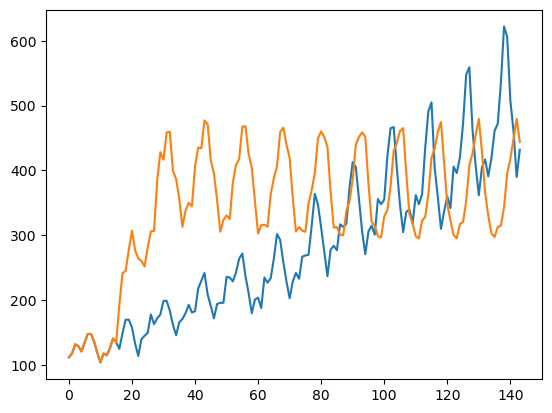

In [120]:
true_pass = scaler.inverse_transform(passengers)
pred_pass = scaler.inverse_transform(pred.reshape(-1,1))

plt.plot(true_pass)
plt.plot(pred_pass)

plt.show()

run["test/true_passengers"].extend(list(true_pass))
run["test/predicted_passengers"].extend(list(pred_pass))

In [121]:
run.stop()

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 4 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 4 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/sergey.b.berezin/Passengers/e/PAS-14/metadata
